# 250 species of birds classification Using the VGG16 Pre-trained Model

## Angelos Nikolas

### The dataset is available at: https://www.kaggle.com/datasets/gpiosenka/100-bird-species/code

In [1]:
#Importing libraries
import random
import tensorflow as tf

In [2]:
#Setting seed
random.seed(42) 

# Processing Data

In [3]:
#Setting up the data and splitting it into training and test sets
generator = tf.keras.preprocessing.image.ImageDataGenerator()

train = generator.flow_from_directory("/home/azureuser/localfiles/birdsdata/train/", class_mode= 'categorical', batch_size=32, target_size=(130,130))
test = generator.flow_from_directory("/home/azureuser/localfiles/birdsdata/test/", class_mode= 'categorical', batch_size=32, target_size=(130,130))
valid = generator.flow_from_directory("/home/azureuser/localfiles/birdsdata/valid/", class_mode= 'categorical', batch_size=32, target_size=(130,130))

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


# Build transfer learning model

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(
    weights='imagenet',  
    input_shape=(130, 130, 3),
    include_top=False) 

# freezing the model
base_model.trainable = False
# Specifying the input shape
inputs = tf.keras.Input(shape=(130, 130, 3))

x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalMaxPooling2D()(x)
# Output layer is set to 250 for the classification of the 250 bird classes
outputs = tf.keras.layers.Dense(250, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss= tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 130, 130, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               128250    
Total params: 14,842,938
Trainable params: 128,250
Non-trainable params: 14,714,688
_________________________________________________________________


# Fitting the model

In [5]:
history = model.fit(train, validation_data=valid, epochs=5)

Epoch 1/5
1101/1101 [==============================] - 979s 890ms/step - loss: 34.7376 - categorical_accuracy: 0.3435 - precision: 0.3453 - recall: 0.3431 - val_loss: 13.5781 - val_categorical_accuracy: 0.6416 - val_precision: 0.6426 - val_recall: 0.6416
Epoch 2/5
1101/1101 [==============================] - 976s 886ms/step - loss: 12.2163 - categorical_accuracy: 0.6398 - precision: 0.6410 - recall: 0.6390 - val_loss: 11.9984 - val_categorical_accuracy: 0.7112 - val_precision: 0.7118 - val_recall: 0.7112
Epoch 3/5
1101/1101 [==============================] - 977s 887ms/step - loss: 8.4831 - categorical_accuracy: 0.7237 - precision: 0.7247 - recall: 0.7234 - val_loss: 9.1404 - val_categorical_accuracy: 0.7544 - val_precision: 0.7550 - val_recall: 0.7544
Epoch 4/5
1101/1101 [==============================] - 976s 887ms/step - loss: 6.6467 - categorical_accuracy: 0.7683 - precision: 0

# Fine-Tunning

In [6]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=tf.keras.optimizers.Adam(0.00001),  # Very low learning rate
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(train, epochs=5, validation_data=valid)

Epoch 1/5
1101/1101 [==============================] - 4308s 4s/step - loss: 1.3964 - categorical_accuracy: 0.8583 - val_loss: 1.6334 - val_categorical_accuracy: 0.8384
Epoch 2/5
1101/1101 [==============================] - 4216s 4s/step - loss: 0.2980 - categorical_accuracy: 0.9372 - val_loss: 1.4038 - val_categorical_accuracy: 0.8520
Epoch 3/5
1101/1101 [==============================] - 4216s 4s/step - loss: 0.1206 - categorical_accuracy: 0.9695 - val_loss: 1.5720 - val_categorical_accuracy: 0.8560
Epoch 4/5
1101/1101 [==============================] - 4206s 4s/step - loss: 0.0988 - categorical_accuracy: 0.9737 - val_loss: 1.3884 - val_categorical_accuracy: 0.8672
Epoch 5/5
1101/1101 [==============================] - 4200s 4s/step - loss: 0.1123 - categorical_accuracy: 0.9706 - val_loss: 1.133

In [8]:
model.save("/home/azureuser/cloudfiles/code/Users/c1044433/Task2/model.h5")

# Results

In [9]:
import numpy as np

y_true = test.labels
y_pred = model.predict(test).argmax(axis=1)

In [10]:
acc_test = model.evaluate(test)[1]
print("The testing accuracy is: ", acc_test)

40/40 [==============================] - 32s 797ms/step - loss: 0.8760 - categorical_accuracy: 0.8912
The testing accuracy is:  0.8912000060081482


Note: you may need to restart the kernel to use updated packages.


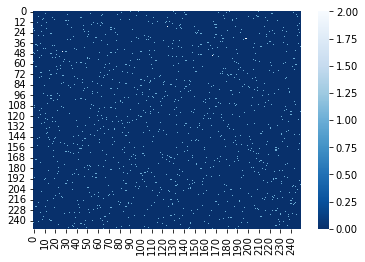

In [13]:
from sklearn.metrics import confusion_matrix
%pip install seaborn
import seaborn as sns

conf = confusion_matrix(y_true=y_true, y_pred=y_pred)

conf_plt = sns.heatmap(conf, fmt='', cmap='Blues_r')